In [150]:
import os
import pandas as pd
from datetime import datetime
from matplotlib import pyplot as plt

# We do only read operations, therefore no user config is necessary.
# Normally the system crashes when there is no config unless we tell it otherwise with this environment variable.
#   0 is default
#   1 means ignore the config
#   2 means ignore the config and don't throw warnings
os.environ["PYWIKIBOT_NO_USER_CONFIG"] = "2"

# Now we can import pywikibot
import pywikibot as pwb

In [16]:
# Setting the correct site
site = pwb.Site(code="en", fam="wikipedia")
site

APISite("en", "wikipedia")

In [40]:
page = pwb.Page(site, u"Barack Obama")
page

Page('Barack Obama')

In [18]:
help(site.search)

Help on method search in module pywikibot.site:

search(searchstring: str, namespaces=None, where='text', get_redirects=False, total=None, content=False, number='[deprecated name of total]', step=NotImplemented, key='[deprecated name of searchstring]', getredirects='[deprecated name of get_redirects]') method of pywikibot.site.APISite instance
    Iterate Pages that contain the searchstring.
    
    Note that this may include non-existing Pages if the wiki's database
    table contains outdated entries.
    
    @see: U{https://www.mediawiki.org/wiki/API:Search}
    
    @param searchstring: the text to search for
    @param where: Where to search; value must be "text", "title" or
        "nearmatch" (many wikis do not support title or nearmatch search)
    @param namespaces: search only in these namespaces (defaults to all)
    @type namespaces: iterable of str or Namespace key,
        or a single instance of those types. May be a '|' separated
        list of namespace identifiers.

In [56]:
epfl_alts = [
    "EPFL",
    "ETH Lausanne",
    "Swiss Federal Institute of Technology",
    "Poly Lausanne",
    "EPF Lausanne",
]

In [96]:
# namespace 0 means we look only at regular pages
search = site.search("ETH Lausanne", where="text", namespaces=0, total=500)

for _, x in zip(range(5), search):
    print(str(x))

[[en:1500 metres]]
[[en:1984 in the sport of athletics]]
[[en:1994 in the sport of athletics]]
[[en:1997 IAAF Grand Prix]]
[[en:1997 World Championships in Athletics]]


Currently Wikipedia does not feature a UID (Unique Identifier) representation of its content. Therefore we will set some ourselves. This is useful for performance and minimizing storage space.

In [97]:
for _, a in zip(range(5), x.categories()):
    print(a)

[[en:Category:1990s in Athens]]
[[en:Category:1997 World Championships in Athletics]]
[[en:Category:1997 in Greek sport]]
[[en:Category:1997 in athletics (track and field)]]
[[en:Category:Athletics in Athens]]


In [77]:
# We can do the histograms using that.

help(x.revisions)

Help on method revisions in module pywikibot.page:

revisions(reverse: bool = False, total: Union[int, NoneType] = None, content: bool = False, starttime=None, endtime=None, getText='[deprecated name of content]', reverseOrder='[deprecated name of reverse]') method of pywikibot.page.Page instance
    Generator which loads the version history as Revision instances.



In [87]:
temp = [s for s in search]
for u in temp[2].linkedPages():
    print(u)

[[en:ACM DL (identifier)]]
[[en:Applied mathematics]]
[[en:Association for Computing Machinery]]
[[en:BIBSYS (identifier)]]
[[en:BNF (identifier)]]
[[en:CiNii (identifier)]]
[[en:Columbia University]]
[[en:Computational complexity theory]]
[[en:Computational thinking]]
[[en:Computer sciences]]
[[en:Coursera]]
[[en:DBLP (identifier)]]
[[en:Data compression]]
[[en:Digital signal processing]]
[[en:Doctoral advisor]]
[[en:EPFL]]
[[en:ETH Zurich]]
[[en:EURASIP]]
[[en:EURASIP Journal on Advances in Signal Processing]]
[[en:Electrical engineering]]
[[en:Engineering]]
[[en:Ethics]]
[[en:GND (identifier)]]
[[en:Google]]
[[en:Henri Nussbaumer]]
[[en:IEEE]]
[[en:IEEE Jack S. Kilby Signal Processing Medal]]
[[en:ISBN (identifier)]]
[[en:ISNI (identifier)]]
[[en:Jelena Kovacevic]]
[[en:Jelena Kovačević]]
[[en:LCCN (identifier)]]
[[en:MGP (identifier)]]
[[en:Massive open online course]]
[[en:Mathematics Genealogy Project]]
[[en:NDL (identifier)]]
[[en:NKC (identifier)]]
[[en:NLI (identifier)]]
[[en:

In [ ]:
page
mentions of epfl
distance to page with mention

In [124]:
for i, x in enumerate(revs):
    print(i)
    print(x)

In [130]:
help(temp[2].revisions)

Help on method revisions in module pywikibot.page:

revisions(reverse: bool = False, total: Union[int, NoneType] = None, content: bool = False, starttime=None, endtime=None, getText='[deprecated name of content]', reverseOrder='[deprecated name of reverse]') method of pywikibot.page.Page instance
    Generator which loads the version history as Revision instances.



In [212]:
def getCounts(revs, strings, idx):
    page = revs[idx]
    return sum([page.text.count(s) for s in strings])

def getOrUpdate(revs, strings, counts, idx, changes):
    if idx not in counts:
        temp = getCounts(revs, strings, idx)
        counts[idx] = temp
        changes[temp] = min(changes.get(temp) or idx, idx) 
    
    return counts[idx]

pg = temp[3]
cnt = pg.revision_count()
revs = list(temp[2].revisions(content=True))

queue = [(0, cnt - 1)]
cnts = {}
changes = {}

while queue:
    r0, r1 = queue[0]
    queue = queue[1:]
    
    if r0 != r1:
        v0 = getOrUpdate(revs, epfl_alts, cnts, r0, changes)
        v1 = getOrUpdate(revs, epfl_alts, cnts, r1, changes)

        if v0 != v1 and abs(r1 - r0) > 1:
            mid = (r0 + r1) // 2
            queue.extend([(r0, mid), (mid, r1)])

changes = {revs[v]["timestamp"]: k for k, v in changes.items()}
changes = {datetime.combine(k.date(), k.time()): v for k, v in changes.items()}
changes

{datetime.datetime(2017, 7, 11, 19, 10, 58): 12,
 datetime.datetime(2014, 2, 13, 15, 36, 28): 3,
 datetime.datetime(2016, 2, 24, 13, 15, 43): 7,
 datetime.datetime(2016, 12, 30, 21, 34, 24): 9,
 datetime.datetime(2014, 2, 13, 15, 59, 45): 6,
 datetime.datetime(2017, 2, 2, 19, 43, 30): 10,
 datetime.datetime(2016, 2, 24, 19, 46, 25): 8,
 datetime.datetime(2014, 2, 13, 15, 12, 3): 4,
 datetime.datetime(2014, 2, 13, 15, 19, 52): 5}

<AxesSubplot:>

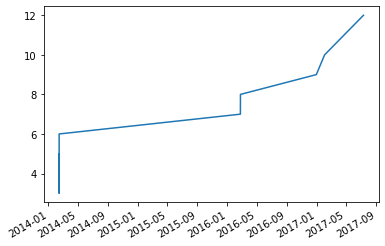

In [213]:
#pandas.DataFrame.from_dict(changes, orient="index")
pd.Series(changes).sort_index().plot()

Will need to handle the problem or redirects and page name changes in the future.

Will need to classify whether we found the subject through keywords or if EPFL was mentioned.